In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from keras import backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, model_from_json
from keras.metrics import CategoricalAccuracy, CategoricalCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, classification_report, SCORERS, log_loss

from numpy.random import seed
from tensorflow.random import set_seed

In [3]:
# load a single file as a numpy array
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

# load a list of files into a 3D array of [observations, timesteps, features(x,y,z)]
def load_group(files, prefix=''):
    loaded = list()
    for f in files:
        data = load_file(prefix + f)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    files = list()
    # body acceleration
    files += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    files += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # total acceleration
    files += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # load input data
    X = load_group(files, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    # load all train
    X_train, y_train = load_dataset_group('train', prefix)
    # load all test
    X_test, y_test = load_dataset_group('test', prefix)
    # zero-offset class values
    y_train = y_train - 1
    y_test = y_test - 1
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    print(f"""Dataset loaded.
Training Set:
X_train {X_train.shape} y_train {y_train.shape}
Test Set:
X_test {X_test.shape} y_test {y_test.shape}""")
    return X_train, y_train, X_test, y_test

In [49]:
X_train, y_train, X_test, y_test = load_dataset(prefix="data/")
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

Dataset loaded.
Training Set:
X_train (7352, 128, 9) y_train (7352, 6)
Test Set:
X_test (2947, 128, 9) y_test (2947, 6)


In [157]:
verbose, epochs, batch_size = 1, 24, 64
# early stopping to choose best epoch
es =EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint(filepath='models/model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', mode='min', save_best_only=True)
# define model
K.clear_session()
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(Dropout(0.1))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2,callbacks=[es, mc])
# evaluate model
accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

Epoch 1/24
92/92 [==============================] - 3s 27ms/step - loss: 0.6469 - accuracy: 0.7286 - val_loss: 0.5747 - val_accuracy: 0.8015
Epoch 2/24
92/92 [==============================] - 4s 40ms/step - loss: 0.2498 - accuracy: 0.9038 - val_loss: 0.3163 - val_accuracy: 0.9021
Epoch 3/24
92/92 [==============================] - 4s 42ms/step - loss: 0.1416 - accuracy: 0.9425 - val_loss: 0.2705 - val_accuracy: 0.9205
Epoch 4/24
92/92 [==============================] - 3s 38ms/step - loss: 0.1122 - accuracy: 0.9546 - val_loss: 0.3120 - val_accuracy: 0.8892
Epoch 5/24
92/92 [==============================] - 4s 41ms/step - loss: 0.0973 - accuracy: 0.9578 - val_loss: 0.2913 - val_accuracy: 0.9225
Epoch 6/24
92/92 [==============================] - 4s 40ms/step - loss: 0.0854 - accuracy: 0.9602 - val_loss: 0.3070 - val_accuracy: 0.9211
Epoch 7/24
92/92 [==============================] - 4s 39ms/step - loss: 0.0928 - accuracy: 0.9595 - val_loss: 0.3239 - val_accuracy: 0.9211
Epoch 8/24
47

In [284]:
history=pd.DataFrame([i.split(" ") for i in fit_history.split(",\n")], columns=["Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

for i in history.columns:
    history[i]=pd.to_numeric(history[i])

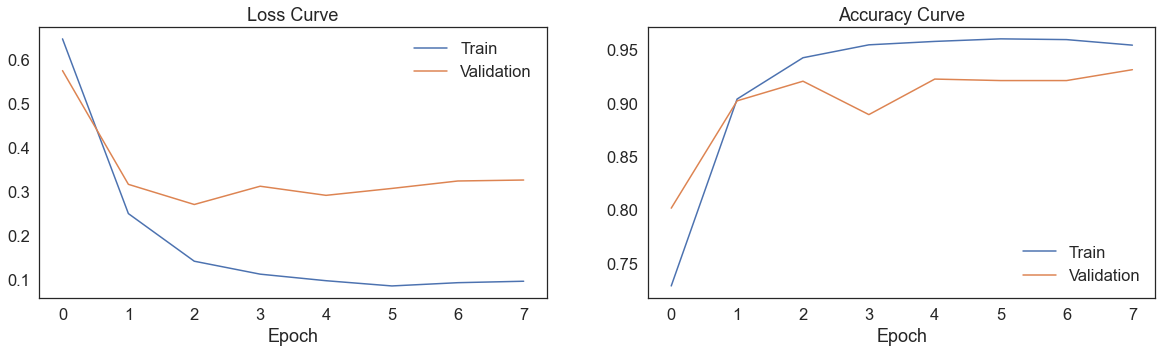

In [391]:
plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.5)
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].set_title('Loss Curve')
axes[0].plot(history["Train Loss"], label='Train', )
axes[0].plot(history["Validation Loss"], label='Validation')
axes[0].set_xlabel("Epoch")
axes[0].legend()
#plot accuracy during training
axes[1].set_title('Accuracy Curve')
axes[1].plot(history["Train Accuracy"], label='Train')
axes[1].plot(history['Validation Accuracy'], label='Validation')
axes[1].legend()
axes[1].set_xlabel("Epoch")
plt.savefig("graph/Training Process Loss vs Accuracy2.png")
plt.show()

In [54]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 13, 128)     24704     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 6, 128)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 4, 256)      98560     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 2, 256)      0         
_________________________________________________________________
dropout (Dropout)            (None, None, 2, 256)      0

In [12]:
# Final evaluation of the model
scores = loaded_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

Test Loss: 0.348009
Test Accuracy: 92.568713%


In [15]:
y_pred=loaded_model.predict(X_test)

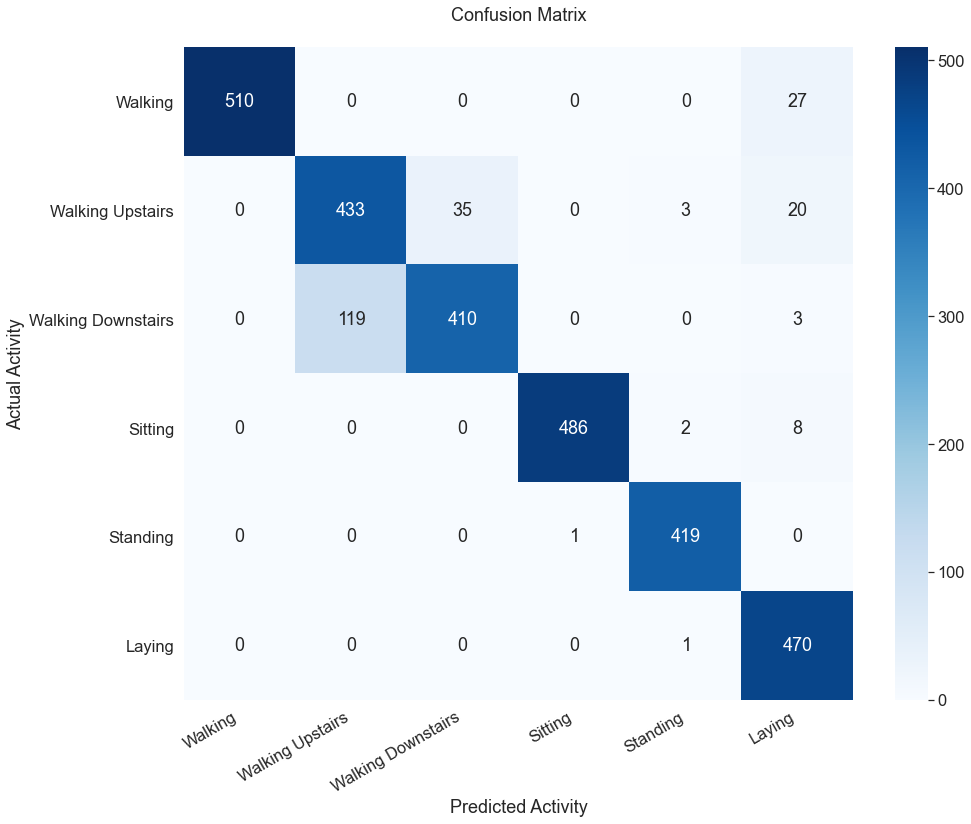

In [16]:
# Confusion Matrix
y_predict=pd.Series([activities[i+1] for i in np.argmax(y_pred, axis=1)])
y_actual=pd.Series([activities[i+1] for i in np.argmax(y_test, axis=1)])


# Code for drawing seaborn heatmaps
class_names = list(activities.values())
df_heatmap = pd.DataFrame(confusion_matrix(y_actual, y_predict) )

plt.style.use('seaborn-whitegrid')
sns.set(style="white", font_scale = 1.5)

fig = plt.figure(figsize=(15,12))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="Blues")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
heatmap.set_xticklabels(class_names)
heatmap.set_yticklabels(class_names)
plt.ylabel('Actual Activity')
plt.xlabel('Predicted Activity')
plt.title("Confusion Matrix\n")
#plt.savefig("graph/Confusion Matrix.png")
plt.show()

In [17]:
cr=classification_report(y_actual, y_predict, target_names=activities.values(), digits=4)
print(cr)

                    precision    recall  f1-score   support

           Walking     1.0000    0.9497    0.9742       537
  Walking Upstairs     0.7844    0.8819    0.8303       491
Walking Downstairs     0.9213    0.7707    0.8393       532
           Sitting     0.9979    0.9798    0.9888       496
          Standing     0.9859    0.9976    0.9917       420
            Laying     0.8902    0.9979    0.9409       471

          accuracy                         0.9257      2947
         macro avg     0.9300    0.9296    0.9275      2947
      weighted avg     0.9300    0.9257    0.9255      2947

